# Fraud detection

## Load data

In [6]:
import pandas as pd

df_fraud = pd.read_csv('data/data_fraud.csv')
df_fraud.head(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
5,2987005,0,86510,49.0,W,5937,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2987006,0,86522,159.0,W,12308,360.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987007,0,86529,422.5,W,12695,490.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2987008,0,86535,15.0,H,2803,100.0,150.0,visa,226.0,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
9,2987009,0,86536,117.0,W,17399,111.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Missing values

In [8]:

import utils
utils.print_percentage_missing_values(df_fraud)

Missing values: 115523073 (45.1%)


We have a lot of missing values, more than 45%

In [9]:
missing_data_count = df_fraud.isnull().sum()
missing_data_percentage = round((missing_data_count / len(df_fraud)) * 100, 1)

missing_data_stats = pd.DataFrame({
    'Missing data (count)': missing_data_count,
    'Missing data (%)': missing_data_percentage
})

missing_data_stats.sort_values(by='Missing data (%)', ascending=False).head(10)

,Missing data (count),Missing data (%)
id_24,585793,99.2
id_25,585408,99.1
id_26,585377,99.1
id_21,585381,99.1
id_22,585371,99.1
id_23,585371,99.1
id_08,585385,99.1
id_07,585385,99.1
id_27,585371,99.1
dist2,552913,93.6


To eliminate missing values, we can start by eliminating columns with the highest number of missing values.

In [10]:
import plotly.graph_objects as go
from tqdm import tqdm

fig = go.Figure()

threshlods = list(range(101))
percentage_missing_values = []

for threshold in tqdm(threshlods):
    df_copy = df_fraud.copy()
    columns_to_drop = missing_data_stats[missing_data_stats['Missing data (%)'] > threshold].index
    df_copy.drop(columns=columns_to_drop, inplace=True)
    percentage = u.percentage_missing_values(df_copy)
    percentage_missing_values.append(percentage)

fig.add_trace(go.Scatter(x=threshlods, y=percentage_missing_values, mode='lines+markers'))
fig.update_layout(title='Percentage of missing values',
                    xaxis_title='Threshold (%)',
                    yaxis_title='Percentage of missing values')

  0%|          | 0/101 [00:00<?, ?it/s]

100%|██████████| 101/101 [01:36<00:00,  1.05it/s]


In [11]:
threshold = 47
columns_to_drop = missing_data_stats[missing_data_stats['Missing data (%)'] > threshold].index
df_fraud.drop(columns=columns_to_drop, inplace=True)

In [12]:
u.print_percentage_missing_values(df_fraud)

Missing values: 10122995 (8.3%)


We have now around 8% of missing values

### Dimension reduction

In [13]:
df_fraud.shape

(590540, 206)

In [14]:
df_fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 206 entries, TransactionID to V321
dtypes: float64(194), int64(4), object(8)
memory usage: 928.1+ MB


We have 8 object columns, which we will need to convert to numerical columns.

### Encoding

To encode object data, we use a OneHotEncoder

In [15]:
from sklearn.preprocessing import OneHotEncoder

object_df = df_fraud.select_dtypes(include=['object'])

encoder = OneHotEncoder(drop='first')
encoded_data = encoder.fit_transform(object_df)

categories = encoder.categories_

encoded_columns = []
for i, col in enumerate(object_df.columns):
    encoded_columns.extend([f"{col}_{category}" for category in categories[i][1:]])

encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoded_columns)

df_fraud = df_fraud.drop(columns=object_df.columns)
df_fraud = pd.concat([df_fraud, encoded_df], axis=1)

In [16]:
df_fraud.shape

(590540, 277)

In [17]:
df_fraud.to_csv('data/data_fraud_cleaned.csv', index=False)

Now, we have 277 columns.To eliminate the multicolinearity, we need to impute the data to calculate the VIF. For this, we will use IterativeImputer.

## Imputation

In [18]:
import pandas as pd

df_fraud = pd.read_csv('data/data_fraud_cleaned.csv')
df_fraud.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,P_emaildomain_ymail.com,P_emaildomain_nan,M1_T,M1_nan,M2_T,M2_nan,M3_T,M3_nan,M6_T,M6_nan
0,2987000,0,86400,68.5,13926,NaN,150.0,142.0,315.0,87.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2987001,0,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
2,2987002,0,86469,59.0,4663,490.0,150.0,166.0,330.0,87.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,2987003,0,86499,50.0,18132,567.0,150.0,117.0,476.0,87.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,2987004,0,86506,50.0,4497,514.0,150.0,102.0,420.0,87.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


In [19]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import warnings
warnings.filterwarnings('ignore')

imputer = IterativeImputer(n_nearest_features=10, random_state=42)
imputer.fit(df_fraud)
df_fraud_imputed = imputer.transform(df_fraud)
df_fraud_imputed = pd.DataFrame(df_fraud_imputed, columns=df_fraud.columns)

In [20]:
df_fraud_imputed.to_csv('data/data_fraud_imputed.csv', index=False)

Now we can reduce again the dimension eliminating multicolinearity. To do this, we are going to use the Variance Inflation Factor (VIF). A VIF higher than 10 reveals a high multicolinearity so we can delete these variables.

Calculating the VIF require a lot of time so we are going to use a random sample to eliminate the multicolinearity.

### Delete multicolinearity with VIF on a sample

In [22]:
import pandas as pd

df_fraud_imputed = pd.read_csv('data/data_fraud_imputed.csv')
df_fraud_imputed.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,P_emaildomain_ymail.com,P_emaildomain_nan,M1_T,M1_nan,M2_T,M2_nan,M3_T,M3_nan,M6_T,M6_nan
0,2987000.0,0.0,86400.0,68.5,13926.0,384.313069,150.0,142.0,315.0,87.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2987001.0,0.0,86401.0,29.0,2755.0,404.000000,150.0,102.0,325.0,87.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
2,2987002.0,0.0,86469.0,59.0,4663.0,490.000000,150.0,166.0,330.0,87.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,2987003.0,0.0,86499.0,50.0,18132.0,567.000000,150.0,117.0,476.0,87.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,2987004.0,0.0,86506.0,50.0,4497.0,514.000000,150.0,102.0,420.0,87.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


In [23]:
size_sample = 5000
df_sampled = df_fraud_imputed.sample(n=size_sample, random_state=42)

In [24]:
from utils import delete_multicollinearity

df_fraud_preprocessed = delete_multicollinearity(df_sampled, 'isFraud', 10) #1h10

Dropped column card6_nan with VIF: inf (41s)
Dropped column M3_nan with VIF: inf (37s)
Dropped column M2_nan with VIF: inf (43s)
Dropped column V307 with VIF: 195690558.9 (44s)
Dropped column V97 with VIF: 34966459.7 (40s)
Dropped column V308 with VIF: 13886833.8 (31s)
Dropped column V96 with VIF: 8241993.1 (40s)
Dropped column V306 with VIF: 4630651.0 (42s)
Dropped column V280 with VIF: 2969670.4 (35s)
Dropped column V95 with VIF: 2017474.1 (34s)
Dropped column V305 with VIF: 1441567.2 (33s)
Dropped column V65 with VIF: 51729782.8 (66s)
Dropped column V41 with VIF: 6177709.8 (68s)
Dropped column V14 with VIF: 1225457.2 (65s)
Dropped column V128 with VIF: 1002481.8 (49s)
Dropped column V126 with VIF: 588742.8 (42s)
Dropped column V279 with VIF: 199070.9 (41s)
Dropped column TransactionID with VIF: 22340.0 (40s)
Dropped column V101 with VIF: 20786.5 (41s)
Dropped column V133 with VIF: 16898.5 (43s)
Dropped column C12 with VIF: 10485.8 (42s)
Dropped column V119 with VIF: 10089.5 (58s)
Dr

In [25]:
columns_to_keep = list(df_fraud_preprocessed.columns) + ['isFraud']
df_fraud_final = df_fraud_imputed[columns_to_keep]

In [42]:
df_fraud_final.to_csv('data/data_fraud_final.csv', index=False)

In [41]:
df_fraud_final.shape

(590540, 125)

Now we have 125 columns, to reduce more the dimension, we can see the correlation between each pair of predictors.

In [2]:
import pandas as pd

df_fraud_preprocessed = pd.read_csv('data/data_fraud_final.csv')

In [14]:
import numpy as np

corr_matrix = df_fraud_preprocessed.corr().abs()
upper_corr_matrix = np.triu(corr_matrix, k=1)
df_upper_corr = pd.DataFrame(upper_corr_matrix, columns=df_fraud_preprocessed.columns, index=df_fraud_preprocessed.columns)
df_upper_corr.head()

,TransactionDT,TransactionAmt,card1,card2,addr1,C3,C5,C7,C9,C14,...,P_emaildomain_yahoo.de,P_emaildomain_yahoo.es,P_emaildomain_yahoo.fr,P_emaildomain_ymail.com,P_emaildomain_nan,M1_nan,M3_T,M6_T,M6_nan,isFraud
TransactionDT,0.0,0.01192,0.010625,0.019669,0.000368,0.007546,0.023800,0.055402,0.032732,0.039721,...,0.001303,0.000323,0.002424,0.002764,0.010070,0.320819,0.256185,0.061788,0.145946,0.013103
TransactionAmt,0.0,0.00000,0.005725,0.016310,0.009123,0.004798,0.030560,0.017061,0.030021,0.022435,...,0.004016,0.000641,0.005700,0.002554,0.029072,0.083438,0.051949,0.101604,0.117025,0.011320
card1,0.0,0.00000,0.000000,0.004798,0.020262,0.004710,0.005752,0.004641,0.004370,0.007366,...,0.003322,0.001902,0.002009,0.000784,0.000410,0.000016,0.001681,0.001479,0.002465,0.013640
card2,0.0,0.00000,0.000000,0.000000,0.028907,0.007019,0.019572,0.008897,0.024731,0.001529,...,0.003105,0.000110,0.001372,0.006144,0.010675,0.066961,0.055356,0.015828,0.106776,0.004082
addr1,0.0,0.00000,0.000000,0.000000,0.000000,0.003233,0.005938,0.001495,0.002641,0.002636,...,0.000124,0.002373,0.000925,0.001720,0.005158,0.020638,0.016677,0.024774,0.032218,0.006954


In [11]:
import plotly.graph_objects as go
from tqdm import tqdm

fig = go.Figure()

threshlods = np.linspace(0, 1, 101)
nb_col2drop = []

for threshold in tqdm(threshlods):
    to_drop = [column for column in df_upper_corr.columns if any(df_upper_corr[column] > threshold)]
    nb_col2drop.append(len(to_drop))

fig.add_trace(go.Scatter(x=threshlods, y=nb_col2drop, mode='lines+markers'))
fig.update_layout(title='Number of columns to drop',
                    xaxis_title='Threshold (%)',
                    yaxis_title='Number of columns to drop')

  0%|          | 0/101 [00:00<?, ?it/s]

100%|██████████| 101/101 [00:00<00:00, 245.12it/s]


In [25]:
# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = df_fraud_preprocessed.drop(columns='isFraud')
y = df_fraud_preprocessed['isFraud']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

nb_components = np.arange(10, 105, 5)
variances = []

for n in tqdm(nb_components):
    pca = PCA(n_components=n)
    pca.fit(X_scaled)
    variances.append(pca.explained_variance_ratio_.sum())

fig = go.Figure()
fig.add_trace(go.Scatter(x=nb_components, y=variances, mode='lines+markers'))
fig.update_layout(title='Explained variance ratio',
                    xaxis_title='Number of components',
                    yaxis_title='Explained variance ratio')

100%|██████████| 19/19 [02:54<00:00,  9.19s/it]


In [26]:
nb_components = 35
pca = PCA(n_components=nb_components)
X_pca = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(X_pca, columns=[f'PC{i}' for i in range(1, nb_components + 1)])
df_pca['isFraud'] = y
df_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,isFraud
0,1.251587,-0.488764,-1.411336,-1.513690,1.152828,0.409959,0.493672,0.791833,0.513962,-0.155776,...,0.401492,0.079803,-0.034205,0.276225,-0.384662,0.481998,0.582489,-0.300067,-0.254769,0.0
1,-1.304886,-1.028321,-0.219636,-0.071615,0.831524,0.424945,0.001436,0.162295,-0.427354,-0.760685,...,0.004347,0.151705,-0.029141,0.050761,0.031968,0.142299,0.036609,-0.035061,-0.038671,0.0
2,1.240483,-0.727944,-1.691752,-0.822673,1.022479,-0.181421,0.234542,-0.790251,0.499296,0.937267,...,1.146856,-4.106451,-1.567944,1.147998,-0.135984,-0.475011,-0.745876,-0.703443,-0.627332,0.0
3,1.471937,1.511752,1.114298,-1.041947,1.785683,-1.213357,0.554701,-1.797466,0.187887,-0.080578,...,-0.344877,-0.179451,-0.006782,0.053958,0.014231,-0.006990,-0.081038,-0.119090,-0.070752,0.0
4,-4.336551,-0.892373,0.318611,0.093706,0.550450,0.235548,0.438633,0.104698,-0.375216,-0.948892,...,-0.055848,-0.192107,-0.423234,0.205450,-0.109095,-0.026735,-0.164722,0.140223,-0.238290,0.0


In [ ]:
df_pca.to_csv('data/data_fraud_pca.csv', index=False)

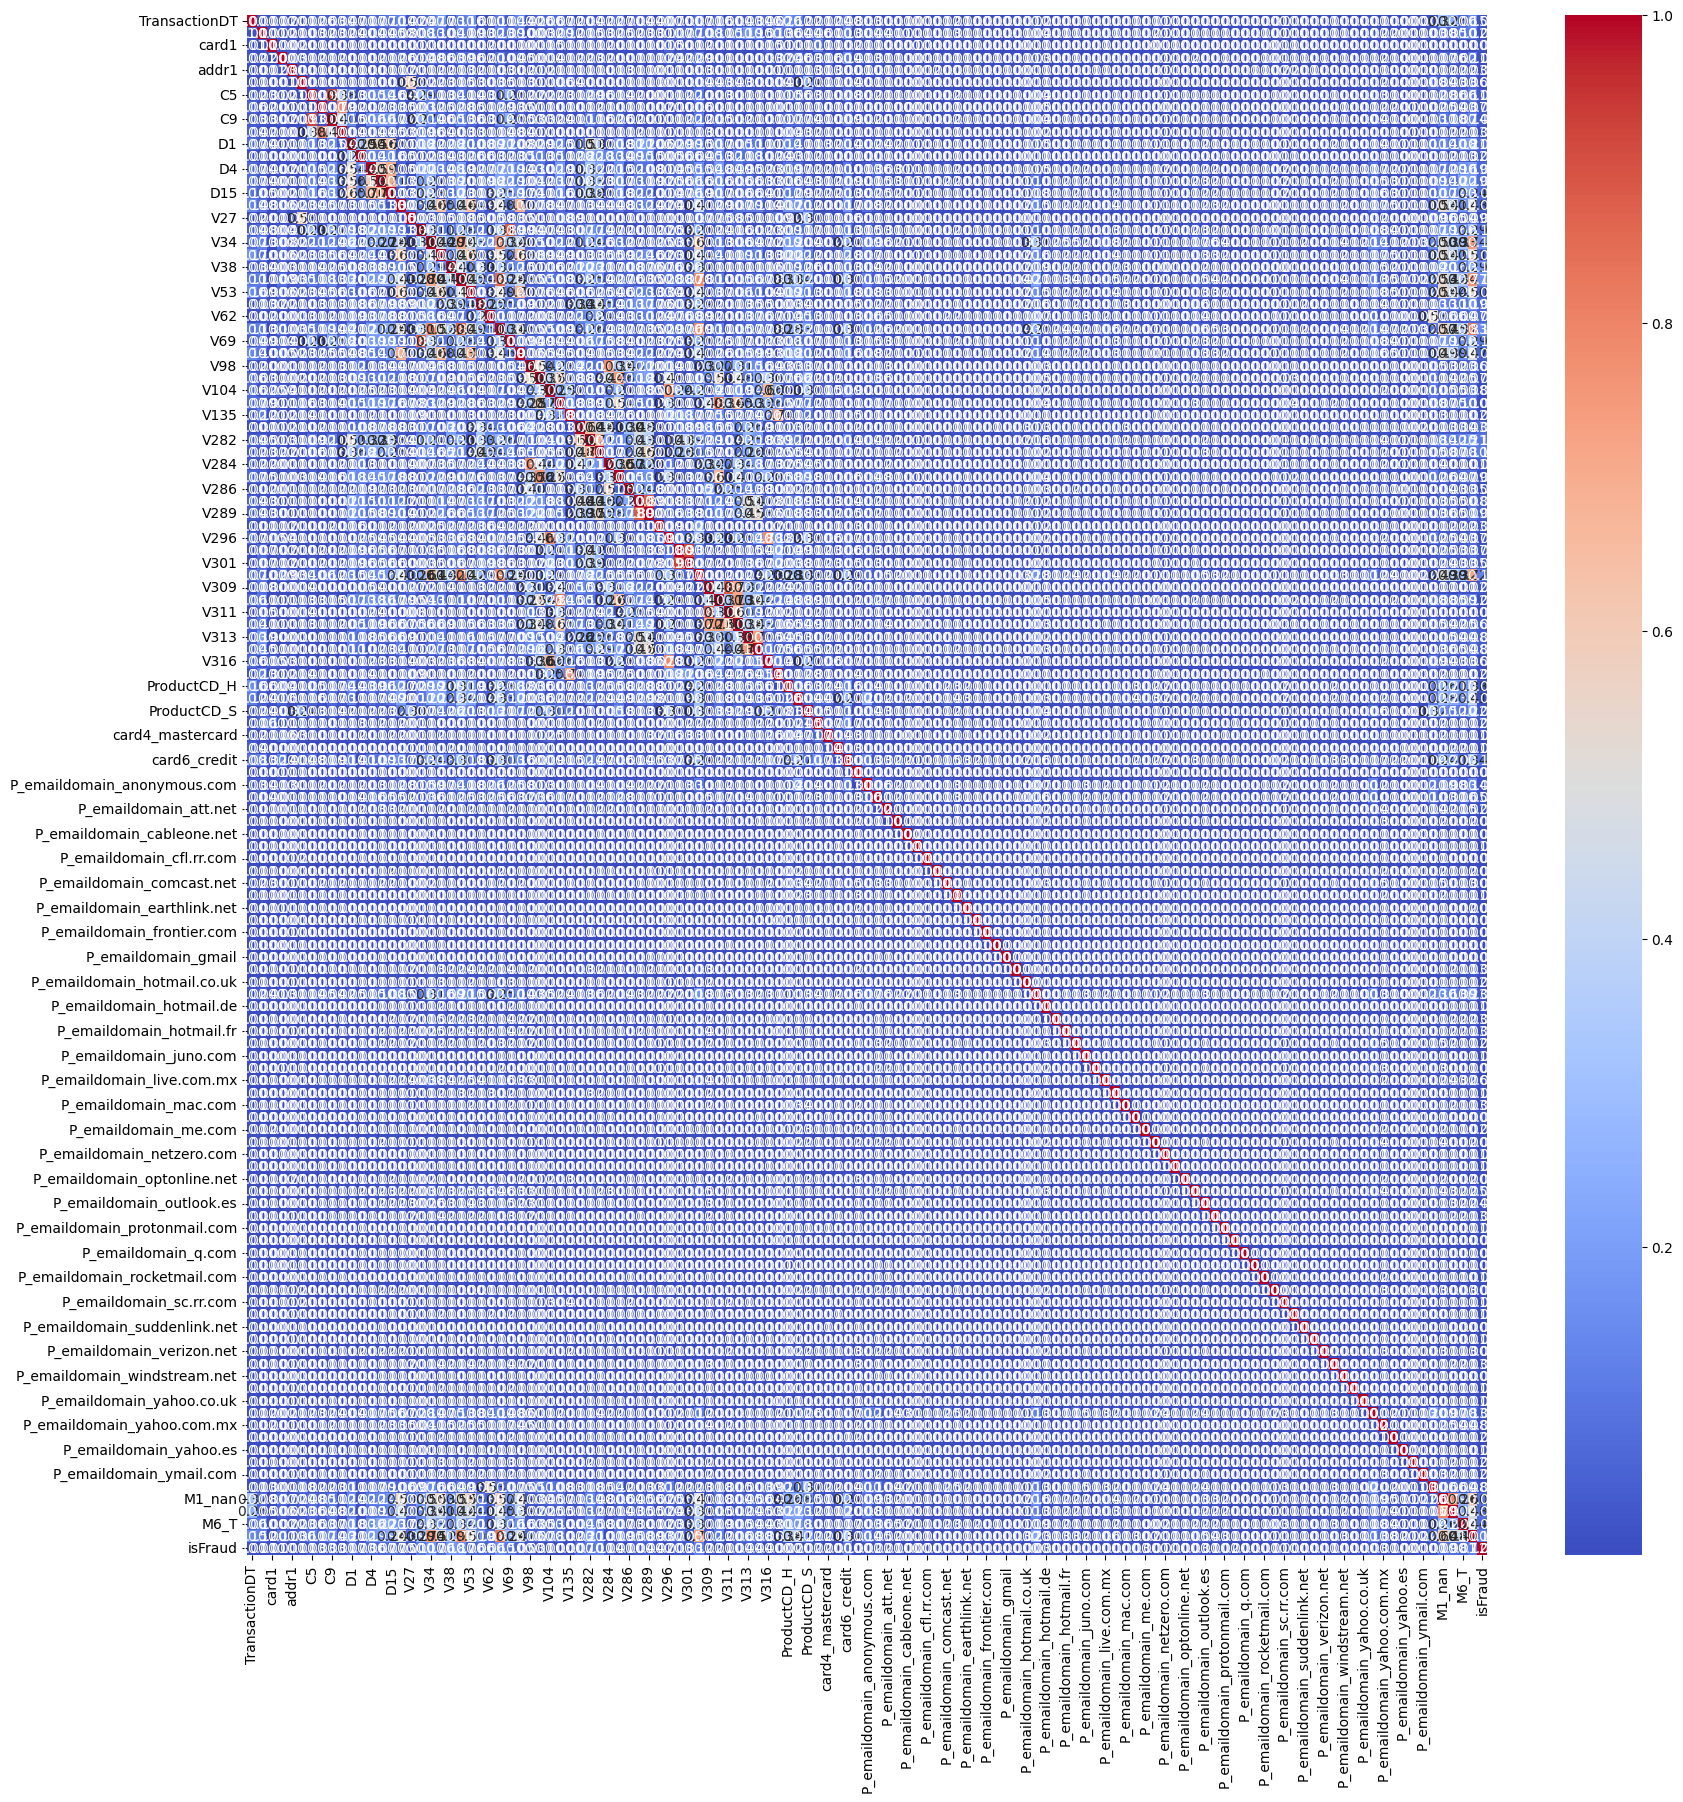

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))

sns.heatmap(df_fraud_preprocessed.corr().apply(abs), cmap='coolwarm')
plt.show()

In [ ]:
col_eda = ['D2', 'D4', 'D5', 'D10', 'D15', 'V12', 'V22', 'V30', 'V36', 'V40']
data_eda = df_fraud_preprocessed[col_eda]

In [ ]:
data_eda.describe()

,D2,D4,D5,D10,D15,V12,V22,V30,V36,V40
count,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000
mean,91.273735,138.788598,33.968343,116.021565,154.327641,0.505598,0.175581,0.413451,0.550874,0.232755
std,154.674688,174.496901,62.737528,172.740423,190.323319,0.497391,0.357500,0.520480,0.482501,0.491472
min,-57.101829,-419.230992,-141.067547,-136.326287,-741.872495,-0.489545,-0.246607,-0.243705,-0.657509,-0.265429
25%,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.935475,71.128466,22.000000,41.000000,83.000000,0.152209,0.000000,0.000000,0.438496,0.000000
75%,115.000000,222.858328,29.357035,157.000000,263.475069,1.000000,0.000000,1.000000,1.000000,0.050732
max,640.000000,869.000000,819.000000,876.000000,879.000000,3.000000,8.000000,9.000000,5.000000,24.000000


The repartition of the values is very umbalanced. For exemple, for 'V34', we have the same 1st and 3rd quartile (0), which means that more than 75% of the values are equal to 0. The same goes for 'V56' and 'V70'.

### Histplot

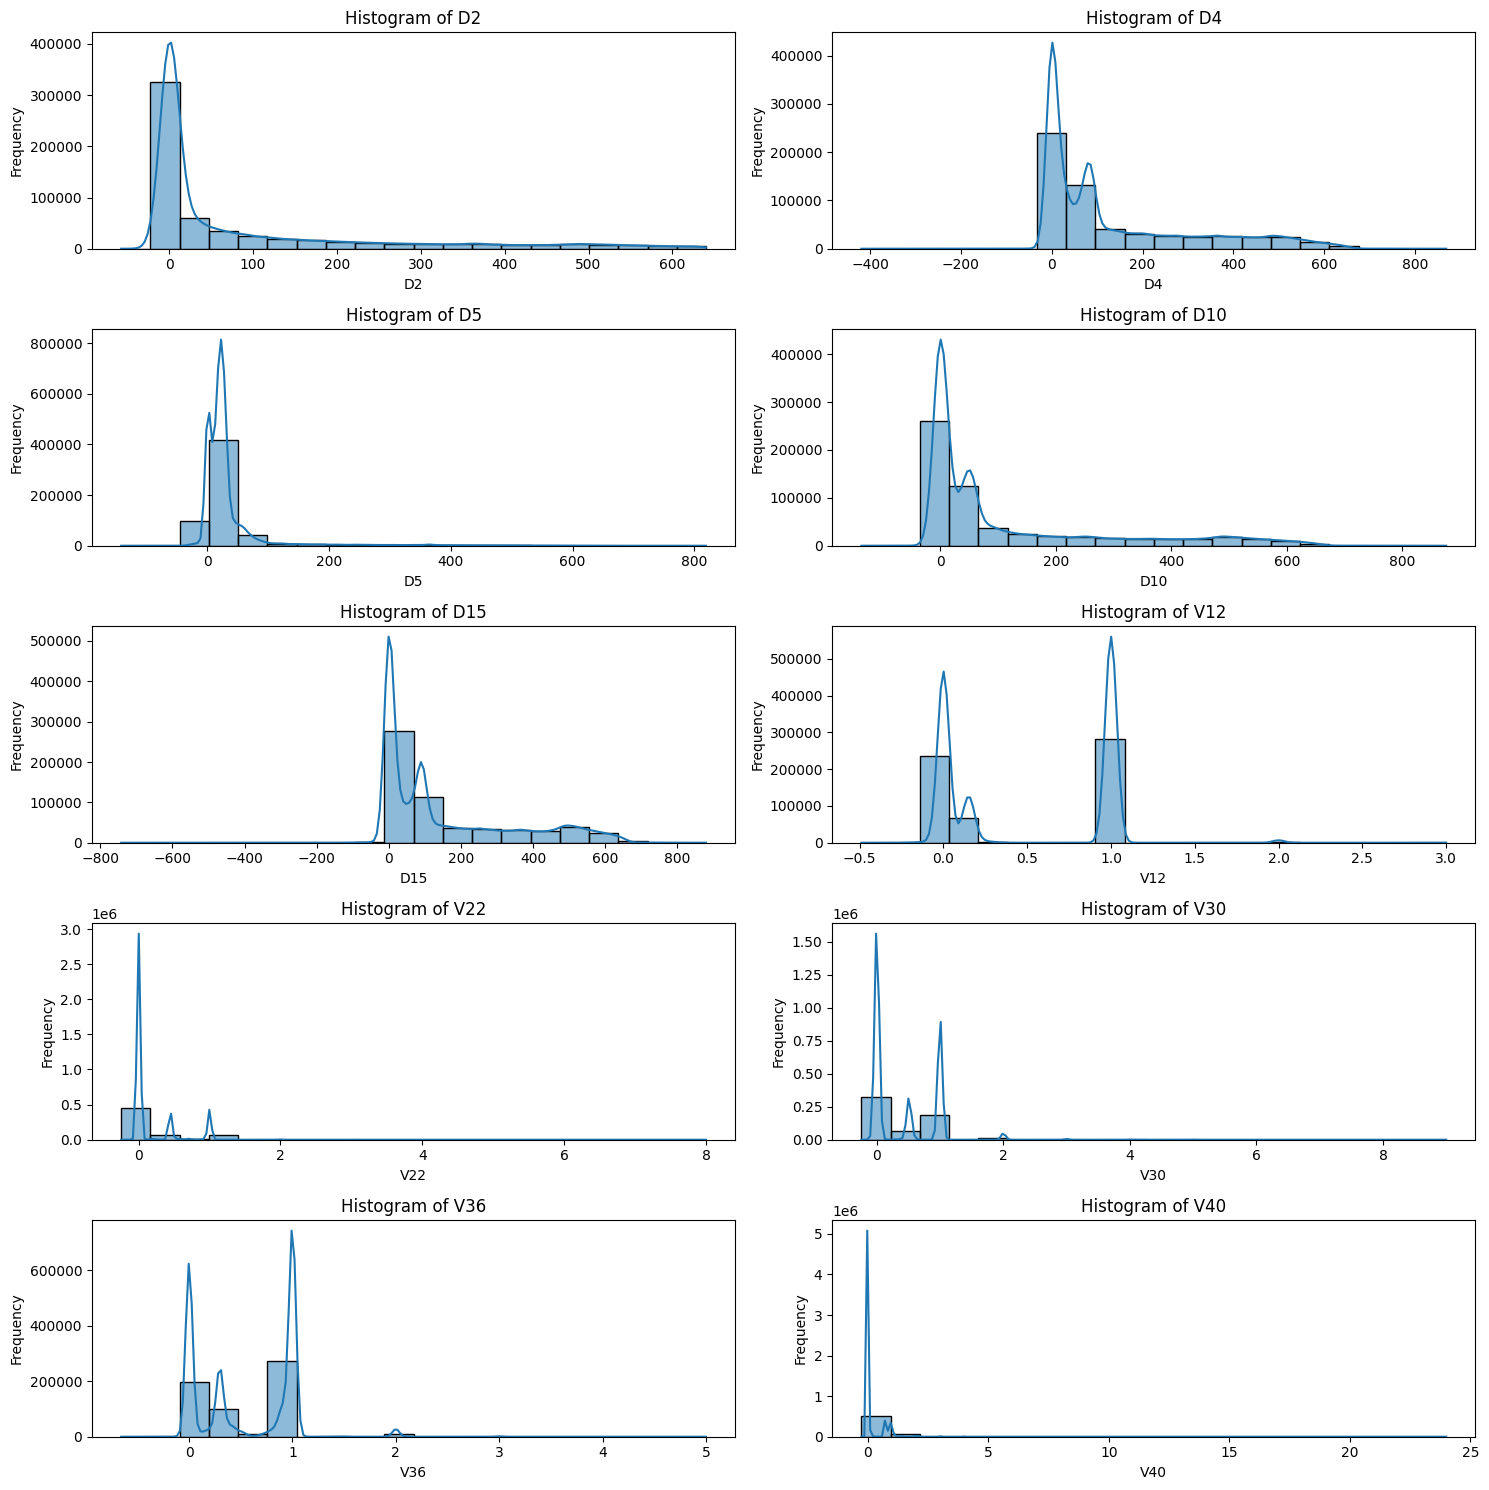

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(5, 2, figsize=(15, 15))
axes = axes.flatten()

for i, var in enumerate(data_eda.columns):
    sns.histplot(data=data_eda, x=var, bins=20, kde=True, ax=axes[i])
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Histogram of {var}')

plt.tight_layout()
plt.show()


With these histoplot, we can validate that the data is very unbalanced. We can see that the data is very skewed and that the distribution is not normal. This can be because of the presence of outliers in the data. We can also see that the data is very sparse, with a lot of zeros in the data. This can be because of the presence of missing values in the data.

Let's see if we have outliers with plot

### Boxplot

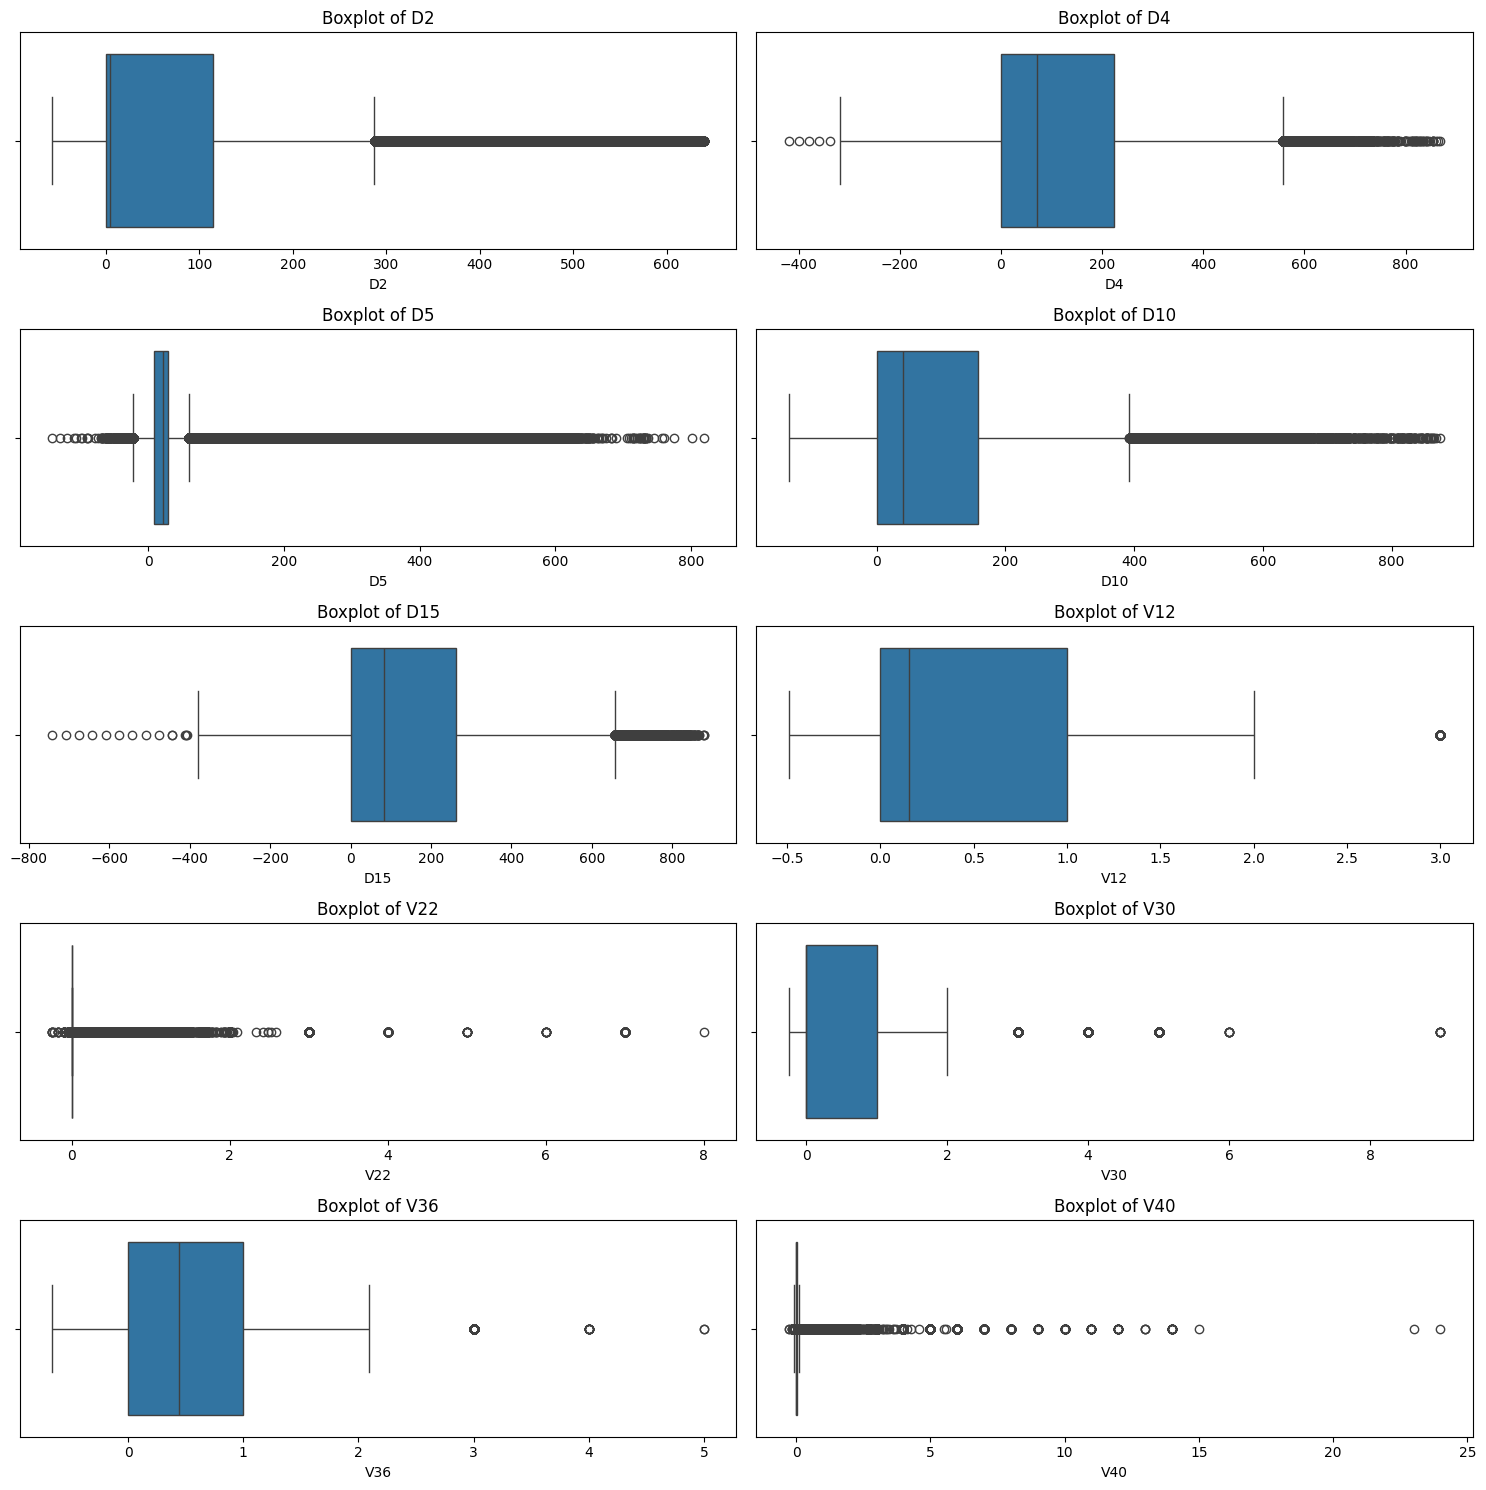

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(5, 2, figsize=(15, 15))
axes = axes.flatten()

for i, var in enumerate(data_eda.columns):
    sns.boxplot(x=data_eda[var], ax=axes[i])
    axes[i].set_xlabel(var)
    axes[i].set_title(f'Boxplot of {var}')

plt.tight_layout()
plt.show()

We these plots, we can see that the variables have a lot of outliers. This can be beacause of the missing values and the imputation with the IterativeImputer.
We will keep these outliers for now.